In [1]:
import torch
torch.set_default_dtype(torch.float64)

from reggae.utilities import save, load
from reggae.gp.variational.models import MLPLFM, ExponentialLFM
from reggae.utilities import inv_softplus
from reggae.data_loaders.ndp_datasets import DeterministicLotkaVolteraData
from torch.utils.data import Dataset, DataLoader
from reggae.data_loaders import load_humanp53
from reggae.plot.variational_plotters import Plotter
from matplotlib import pyplot as plt

import numpy as np

f64 = np.float64

Lotka-Voltera is in {self.mode} mode.
Creating dataset...
2


100%|██████████| 50/50 [00:00<00:00, 510.53it/s]


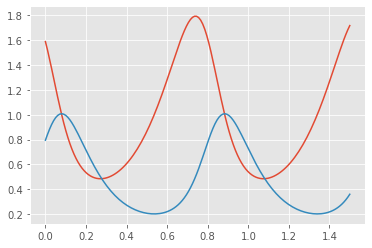

In [2]:
dataset = DeterministicLotkaVolteraData(alpha = 2./3,
                        beta = 4./3, gamma = 1., delta = 1.,
                        num_samples=50)
x_min, x_max = 0.0, 1.5
initial_x = -0.1

print(len(dataset.data[0]))
plt.plot(dataset.data[0][0], dataset.data[0][1])

num_latents = 2
num_outputs = 2

t_predict = torch.linspace(x_min, x_max, 50)
t_inducing = torch.linspace(f64(x_min), f64(x_max), 5, dtype=torch.float32).reshape((-1, 1))
t_observed = dataset.data[0][0].view(-1)
output_names = np.array(['pred','prey'])

In [7]:
class Trainer:
    """
    Trainer

    Parameters
    ----------
    model: .
    optimizer:
    dataset: Dataset where t_observed (T,), m_observed (J, T).
    inducing timepoints.
    """
    def __init__(self, model, optimizer: torch.optim.Optimizer, dataset: Dataset):
        self.num_epochs = 0
        self.kl_mult = 0
        self.optimizer = optimizer
        self.model = model
        self.t_observed = dataset.data[0][0].view(-1)
        self.num_outputs = dataset.data[0][1].shape[1]
        self.data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
        self.losses = np.empty((0, 2))

    def train(self, epochs=20, report_interval=1, plot_interval=20, rtol=1e-5, atol=1e-6, num_samples=5):
        losses = list()
        end_epoch = self.num_epochs+epochs
        plt.figure(figsize=(4, 2.3))
        for epoch in range(epochs):
            for i, data in enumerate(self.data_loader):
                t, y = data
                # for now we don't batch
                t, y = t[0].reshape(-1), y[0].transpose(0, 1)

                self.optimizer.zero_grad()

                # with ef.scan():
                initial_value = torch.zeros((self.num_outputs, 1), dtype=torch.float64)
                output = self.model(t, initial_value, rtol=rtol, atol=atol, num_samples=num_samples)
                output = torch.squeeze(output)

                # Calc loss and backprop gradients
                mult = 1
                if self.num_epochs <= 10:
                    mult = self.num_epochs/10

                ll, kl = self.model.elbo(y, output, mult)
                total_loss = -ll + kl
                total_loss.backward()
                self.optimizer.step()

            if (epoch % report_interval) == 0:
                print('Epoch %d/%d - Loss: %.2f (%.2f %.2f)' % (
                    self.num_epochs + 1, end_epoch,
                    total_loss.item(),
                    -ll.item(), kl.item()
                ))
                self.print_extra()

            losses.append((ll.item(), kl.item()))
            self.after_epoch()

            if (epoch % plot_interval) == 0:
                plt.plot(self.t_observed, output[0].detach().numpy(), label='epoch'+str(epoch))
            self.num_epochs += 1
        plt.legend()

        losses = np.array(losses)
        self.losses = np.concatenate([self.losses, losses], axis=0)

        return output
    def print_extra(self):
        pass
    def after_epoch(self):
        pass

class TranscriptionalTrainer(Trainer):
    def __init__(self, model, optimizer: torch.optim.Optimizer, dataset: Dataset):
        super(TranscriptionalTrainer, self).__init__(model, optimizer, dataset)
        self.basalrates = list()
        self.decayrates = list()
        self.lengthscales = list()
        self.sensitivities = list()
        self.mus = list()
        self.cholS = list()

    def print_extra(self):
        print('b: %.2f d %.2f s: %.2f λ: %.3f' % (
            self.model.basal_rate[0].item(),
            self.model.decay_rate[0].item(),
            self.model.sensitivity[0].item(),
            self.model.lengthscale[0].item()
        ))

    def after_epoch(self):
        self.basalrates.append(self.model.basal_rate.detach().clone().numpy())
        self.decayrates.append(self.model.decay_rate.detach().clone().numpy())
        self.sensitivities.append(self.model.sensitivity.detach().clone().numpy())
        self.lengthscales.append(self.model.lengthscale.detach().clone().numpy())
        self.cholS.append(self.model.q_cholS.detach().clone())
        self.mus.append(self.model.q_m.detach().clone())
        with torch.no_grad():
            self.model.raw_lengthscale.clamp_(-2.5, inv_softplus(torch.tensor(1., dtype=torch.float64))) # TODO is this needed?
            # TODO can we replace these with parameter transforms like we did with lengthscale
            self.model.sensitivity.clamp_(0.4, 8)
            self.model.basal_rate.clamp_(0, 8)
            self.model.decay_rate.clamp_(0, 8)
            self.model.sensitivity[3] = np.float64(1.)
            self.model.decay_rate[3] = np.float64(0.8)
            self.model.q_m[0, 0] = 0.



In [8]:
model = MLPLFM(num_outputs, num_latents, t_inducing, dataset)
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)

trainer = Trainer(model, optimizer, dataset)

C:\Users\Jacob\Documents\proj\reggae\reggae\gp\variational\models.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inducing_inputs = torch.tensor(t_inducing, requires_grad=False)


### Outputs prior to training:

torch.Size([50, 2, 1])
torch.Size([2, 50])


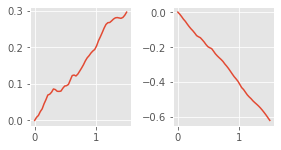

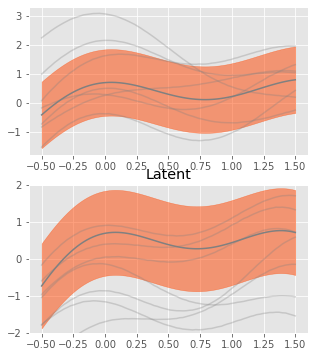

In [9]:
rtol = 5e-3
atol = rtol/10
model_kwargs = {
    'rtol': rtol, 'atol': atol,
    'num_samples': 1
}
plotter = Plotter(model, output_names, t_inducing)
plotter.plot_outputs(t_predict, model_kwargs=model_kwargs)
plotter.plot_tfs()


In [ ]:
tol = 1e-3
# trainer = Trainer(optimizer)
output = trainer.train(10, rtol=tol, atol=tol/10, report_interval=1, plot_interval=2)

torch.Size([150]) torch.Size([2, 150])
torch.Size([150, 2, 1])
torch.Size([150, 2, 1])
torch.Size([150, 2, 1])
torch.Size([150, 2, 1])
torch.Size([150, 2, 1])
torch.Size([2, 150]) torch.Size([2, 150])
torch.Size([150]) torch.Size([2, 150])
torch.Size([150, 2, 1])
torch.Size([150, 2, 1])
torch.Size([150, 2, 1])
torch.Size([150, 2, 1])
torch.Size([150, 2, 1])
torch.Size([2, 150]) torch.Size([2, 150])
torch.Size([150]) torch.Size([2, 150])
torch.Size([150, 2, 1])
torch.Size([150, 2, 1])
torch.Size([150, 2, 1])
torch.Size([150, 2, 1])
torch.Size([150, 2, 1])
torch.Size([2, 150]) torch.Size([2, 150])
torch.Size([150]) torch.Size([2, 150])
torch.Size([150, 2, 1])
torch.Size([150, 2, 1])
torch.Size([150, 2, 1])
torch.Size([150, 2, 1])
torch.Size([150, 2, 1])
torch.Size([2, 150]) torch.Size([2, 150])
torch.Size([150]) torch.Size([2, 150])
torch.Size([150, 2, 1])
torch.Size([150, 2, 1])
torch.Size([150, 2, 1])
torch.Size([150, 2, 1])
torch.Size([150, 2, 1])
torch.Size([2, 150]) torch.Size([2, 1

### Outputs after training

In [ ]:
plotter = Plotter(model, m_df.index, t_inducing)

tol = 1e-3
plotter.plot_losses(trainer, last_x=100)
plot_genes(rtol=tol, atol=tol/10)
plotter.plot_tfs(ylim=(-2, 9))


In [ ]:
save(model, 'nonlinear')

In [ ]:
model = load('nonlinear', NonLinearLFM, num_genes, num_tfs, t_inducing, t_observed, fixed_variance=None)
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
trainer = Trainer(model, optimizer, (t_observed, m_observed))

In [ ]:
titles = ['basal', 'decay', 'sensitivity', 'lengthscale']
datas = [np.array(trainer.basalrates)[:,:,0],
         np.array(trainer.decayrates)[:,:,0],
         np.array(trainer.sensitivities)[:,:,0],
         np.array(trainer.lengthscales)]

plt.figure(figsize=(5, 6))
for i, (title, data) in enumerate(zip(titles, datas)):
    plt.subplot(411 + i)
    plt.title(title)
    # if data.ndim > 1:
    #     for j in range(data.shape[1]):

    plt.plot(data)